# Align multiple slices to reconstruct 3D  
In this case we use `SLAT` to rebuild 3D structure of mouse E15.5 embryo

You need following files as input:
 - count_E15.5_E1S1.MOSTA.h5ad: section 1 of mouse E15.5 embryo
 - count_E15.5_E1S2.MOSTA.h5ad: section 2 of mouse E15.5 embryo
 - count_E15.5_E1S3.MOSTA.h5ad: section 3 of mouse E15.5 embryo
 - count_E15.5_E1S4.MOSTA.h5ad: section 4 of mouse E15.5 embryo

In [1]:
# %matplotlib ipympl  # use this if you want to use interactive plot (only works in Jupyter)
import os
from pathlib import Path
from operator import itemgetter
import time

import scanpy as sc
import numpy as np
import pandas as pd
import torch
from anndata import AnnData
from joblib import Parallel, delayed
from harmony import harmonize

import scSLAT
from scSLAT.model import run_SLAT_multi, load_anndatas, Cal_Spatial_Net, run_SLAT, spatial_match, scanpy_workflow
from scSLAT.viz import match_3D_multi, hist, build_3D
from scSLAT.metrics import region_statistics

In [2]:
sc.set_figure_params(dpi=150, dpi_save=150)

In [3]:
file_path = '../../data/stereo_seq/counts/E15.5'  # Replace it with your file path
file_list = [file for file in Path(file_path).iterdir() if 'MOSTA' in str(file)]
file_list

[PosixPath('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S3.MOSTA.h5ad'),
 PosixPath('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S2.MOSTA.h5ad'),
 PosixPath('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S4.MOSTA.h5ad'),
 PosixPath('../../data/stereo_seq/counts/E15.5/count_E15.5_E1S1.MOSTA.h5ad')]

In [4]:
# For demonstration, we subsample 8000 cells from each dataset
def load_sample(file):
    adata = sc.read_h5ad(file)
    # subsample 8000 cells
    adata = sc.pp.subsample(adata, n_obs=8000, random_state=0, copy=True)
    return adata

In [5]:
adata1,adata2,adata3,adata4 = Parallel(n_jobs=len(file_list)+1)\
    (delayed(load_sample)(file) for file in itemgetter(*[3,1,0,2])(file_list))

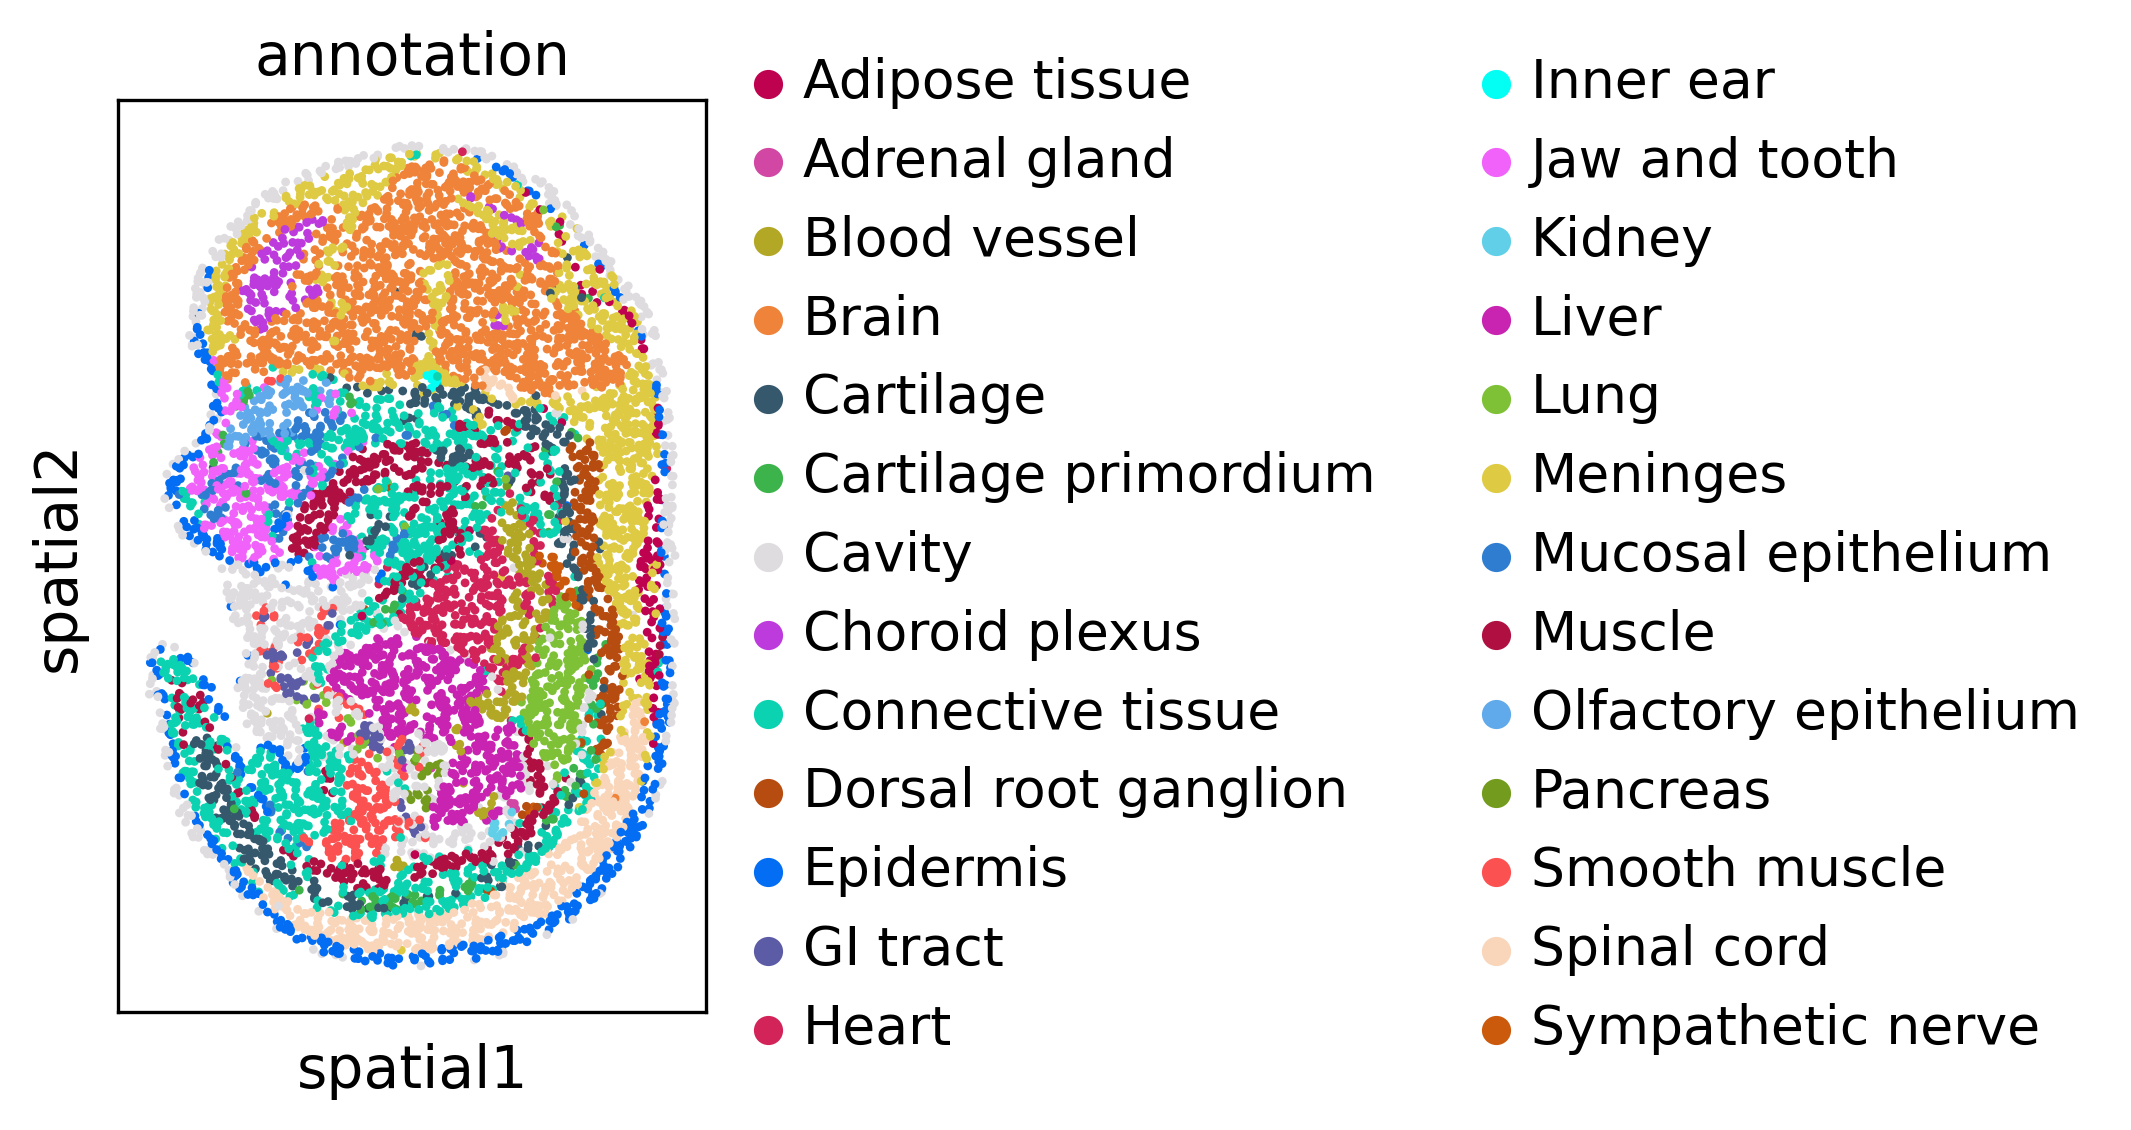

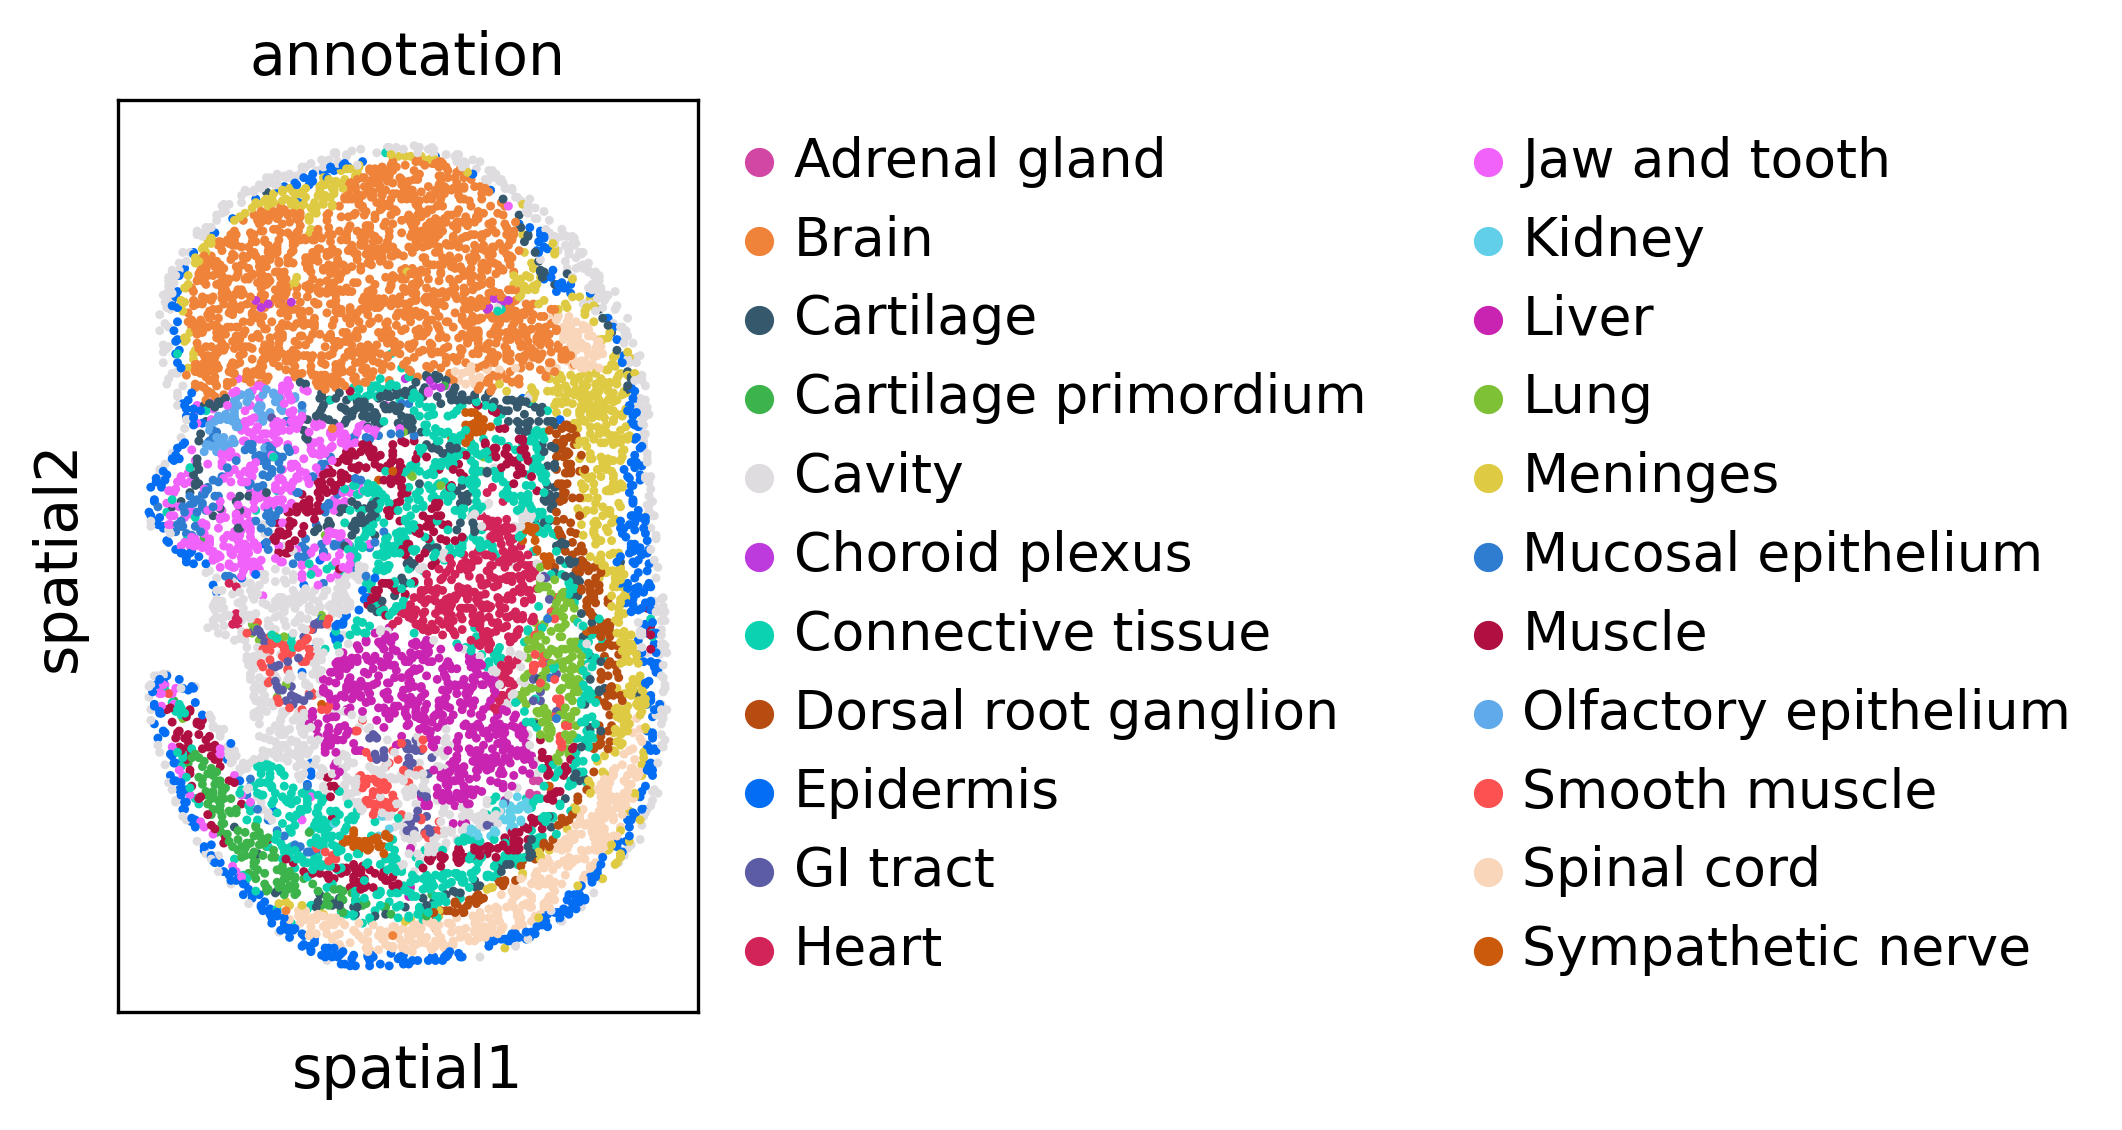

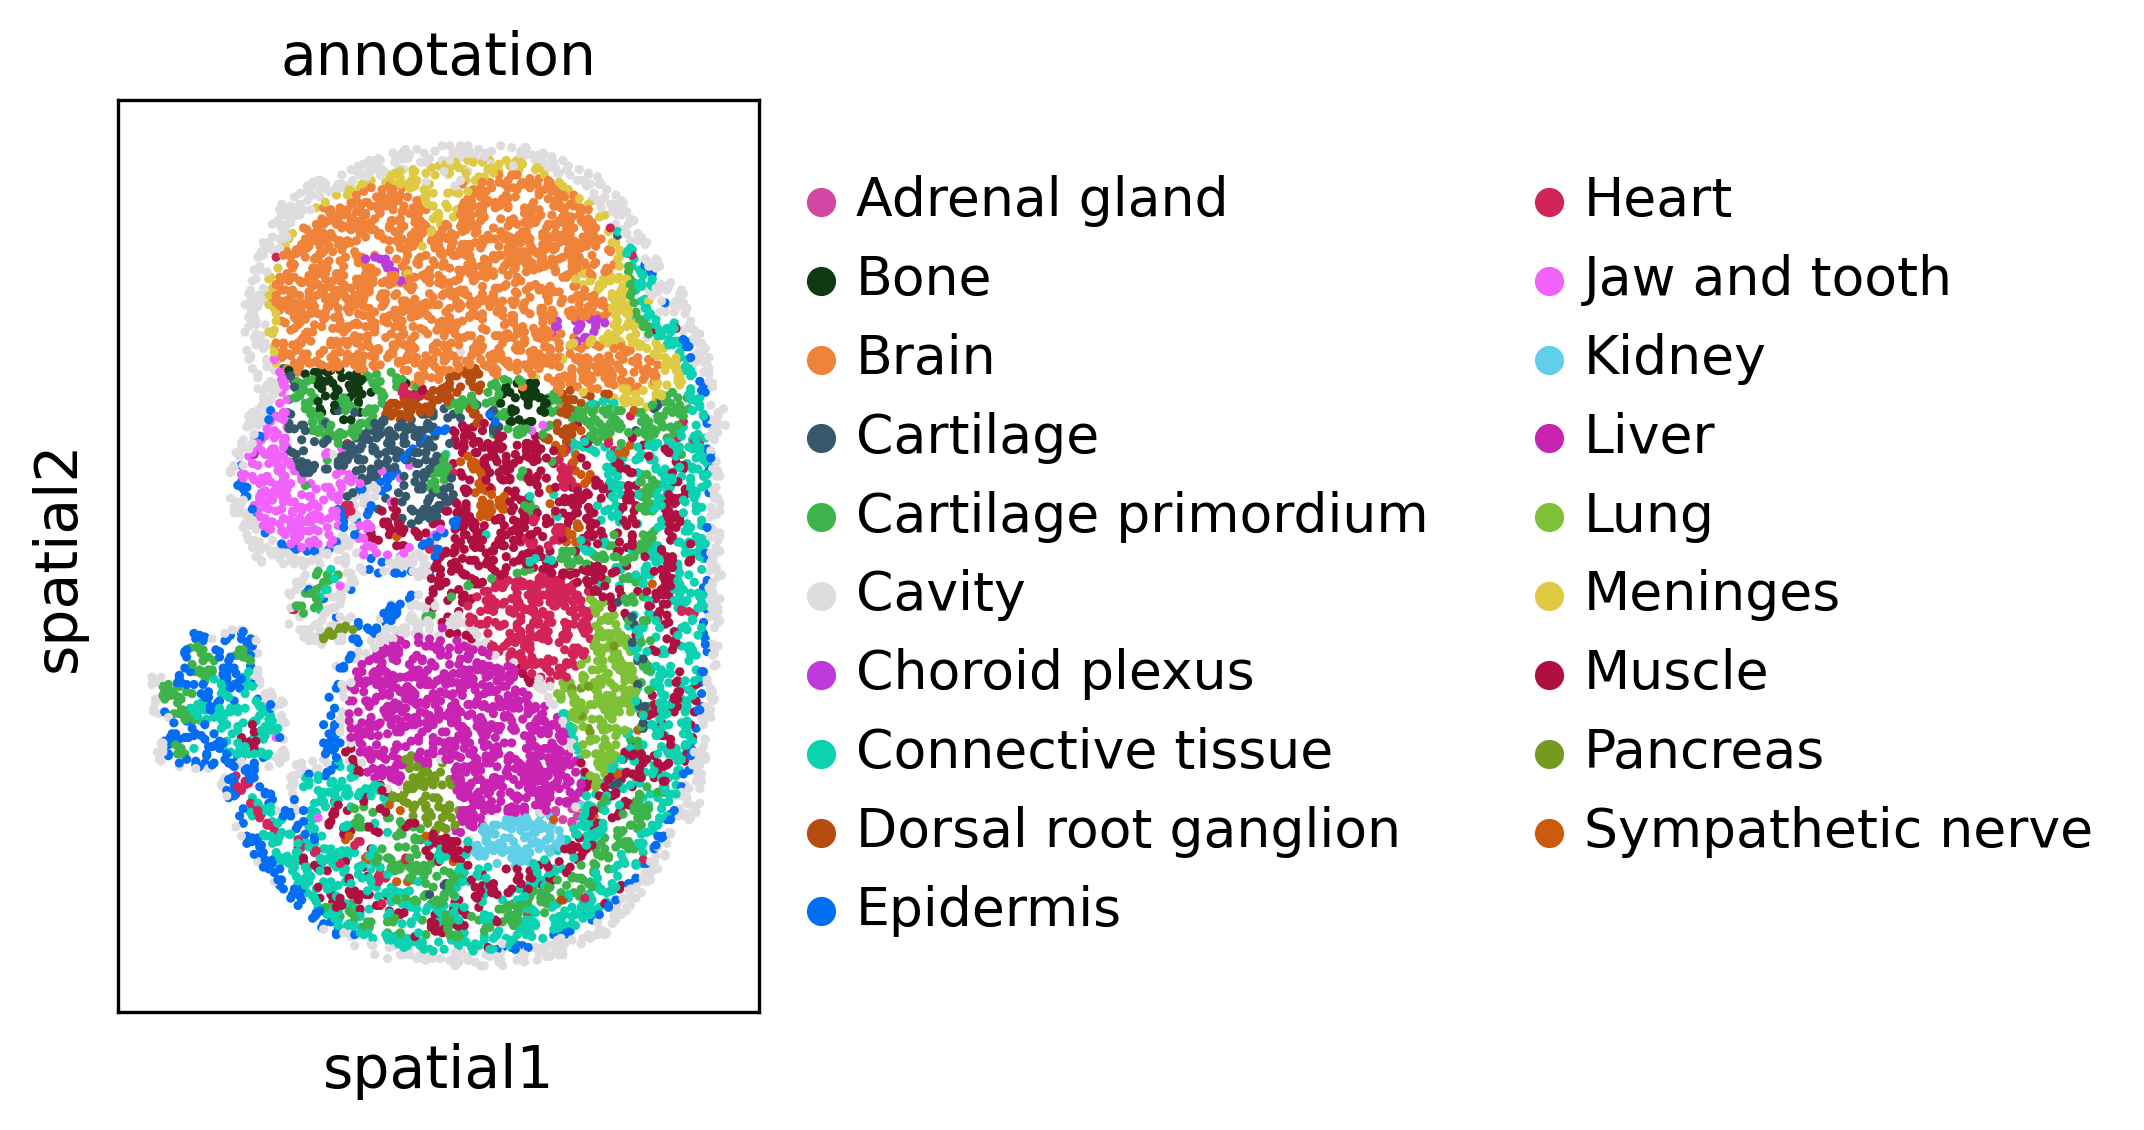

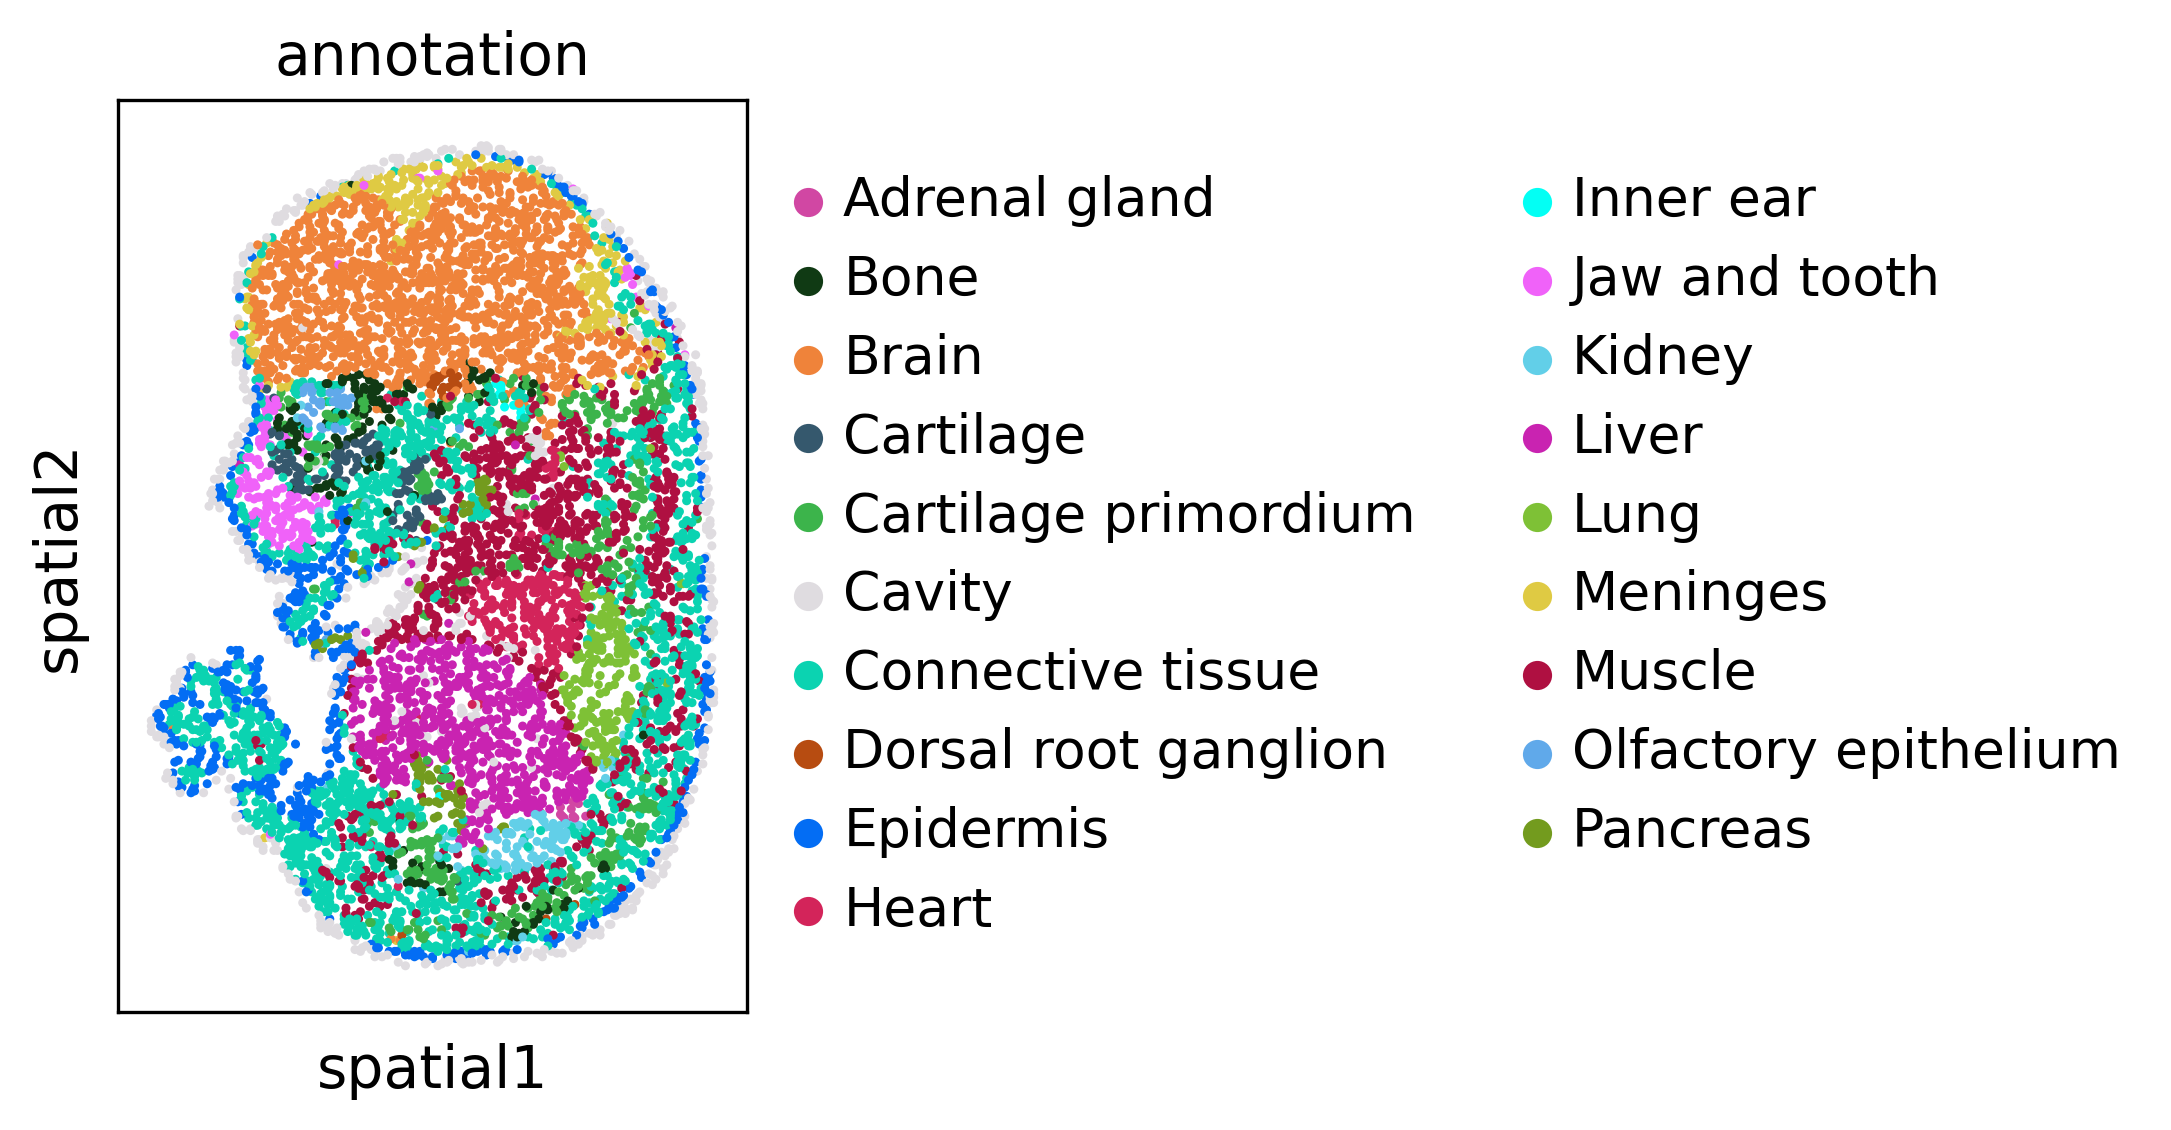

In [6]:
sc.pl.spatial(adata1, spot_size=5, color='annotation')
sc.pl.spatial(adata2, spot_size=5, color='annotation')
sc.pl.spatial(adata3, spot_size=5, color='annotation')
sc.pl.spatial(adata4, spot_size=5, color='annotation')

# run SLAT on multi datasets

In [7]:
start = time.time()
matching_list, zip_res = run_SLAT_multi([adata1,adata2,adata3,adata4], k_cutoff=10)
print(f'Use {time.time()-start:.2f} seconds')

Calculating spatial neighbor graph ...
Calculating spatial neighbor graph ...
The graph contains 90586 edges, 8000 cells.
11.32325 neighbors per cell on average.
The graph contains 90534 edges, 8000 cells.
11.31675 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 90540 edges, 8000 cells.
11.3175 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 90388 edges, 8000 cells.
11.2985 neighbors per cell on average.
Parallel mapping dataset:1 --- dataset:2
Parallel mapping dataset:2 --- dataset:3
Use DPCA feature to format graph
Use DPCA feature to format graph
Parallel mapping dataset:0 --- dataset:1


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Use DPCA feature to format graph


/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/rd2/user/xiacr/SLAT/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)
/rd2/user/xiacr/SLAT/conda/lib/python3.

Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!
Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!
Warning! Dual PCA is using GPU, which may lead to OUT OF GPU MEMORY in big dataset!
Choose GPU:1 as device
Choose GPU:5 as device
Choose GPU:5 as device
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 1.45
Running
---------- epochs: 1 ----------
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
---------- epochs: 2 ----------
Training model time: 1.77
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 2.13
U

In [8]:
index_list = [i[1] for i in zip_res] 
index_list[2].shape

(8000, 20)

Mapping 0th layer 
Mapping 1th layer 
Mapping 2th layer 


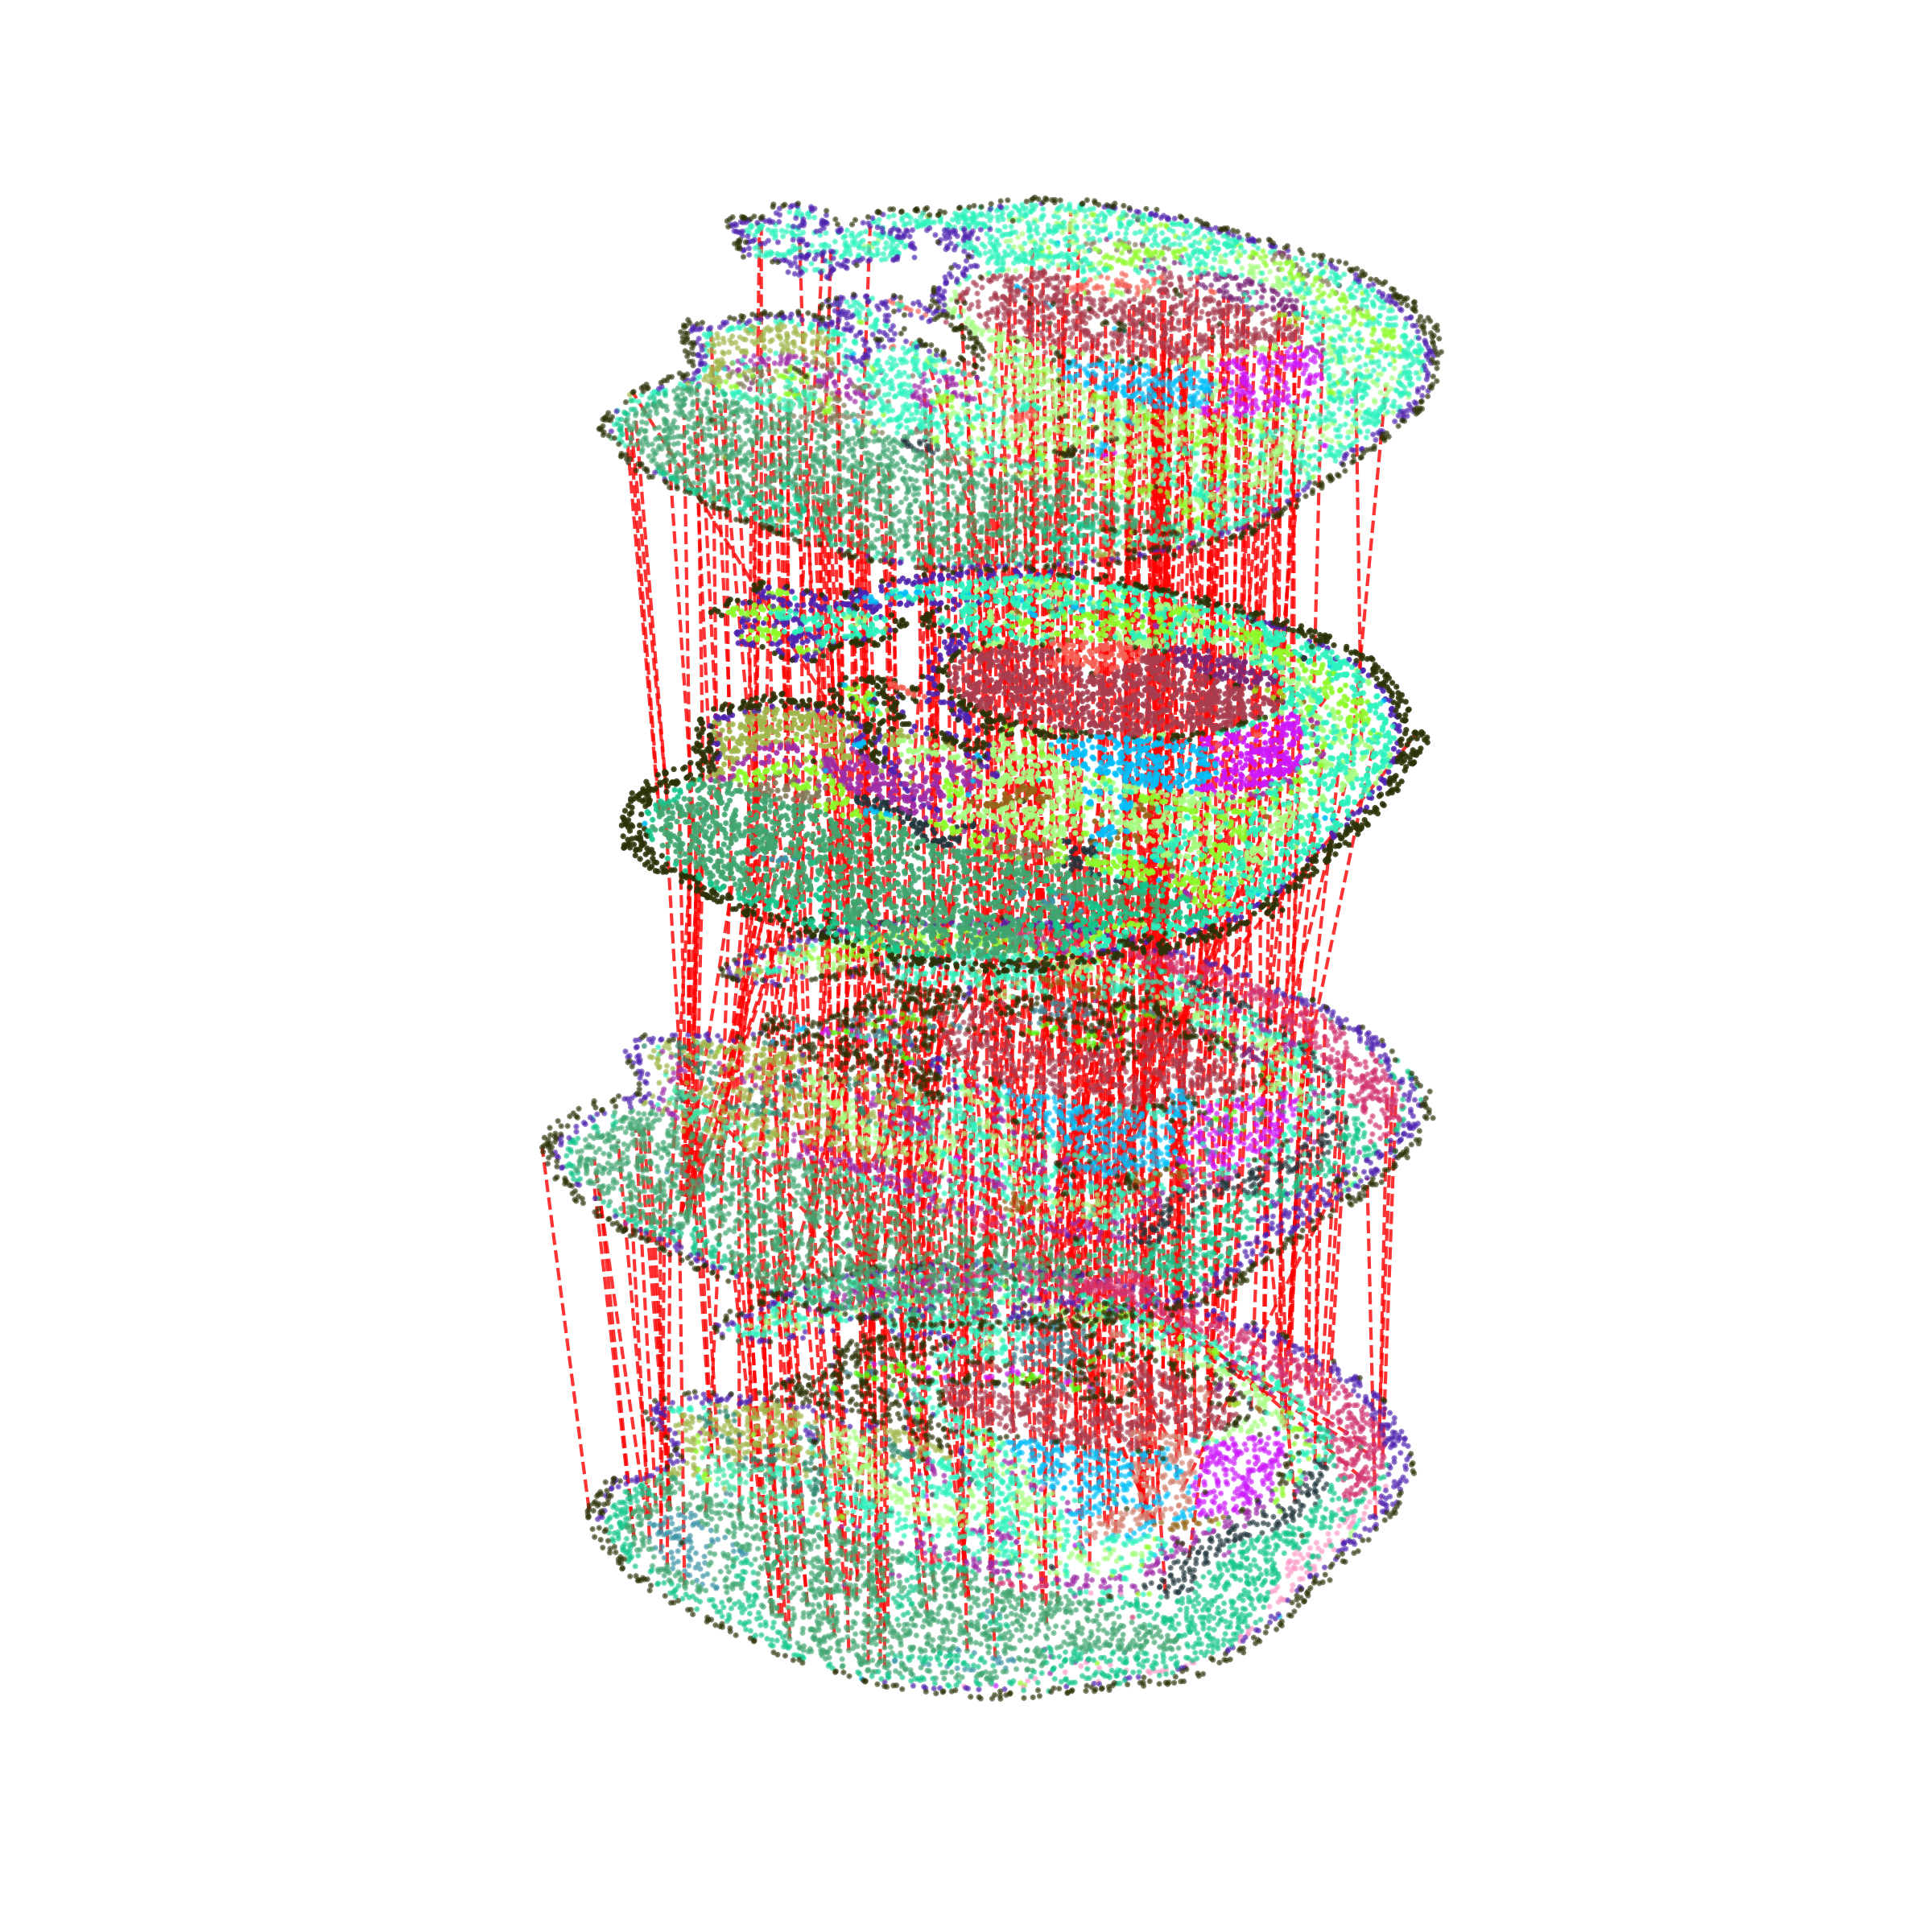

In [9]:
model = build_3D([adata1,adata2,adata3,adata4], matching_list)
model.draw_3D(hide_axis=True, line_color='red', height=10, size=[10,20], line_width=1)